In [1]:
import pickle
import math
import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import imp
import functions

from joblib import Parallel, delayed
from sklearn.manifold import TSNE
import datetime as dt
def padInput(input):
    max_length = np.max([len(i) for i in input])
    input_size = len(input)
    input_pad = np.zeros((input_size, max_length))
    
    for idx_row, row in enumerate(input):
        for idx_col, col in enumerate(row):
            input_pad[idx_row][idx_col]=col
            
    return input_pad

karate_club = [[2, 1],
[3, 1], [3, 2],
[4, 1], [4, 2], [4, 3],
[5, 1],
[6, 1],
[7, 1], [7, 5], [7, 6],
[8, 1], [8, 2], [8, 3], [8, 4],
[9, 1], [9, 3],
[10, 3],
[11, 1], [11, 5], [11, 6],
[12, 1],
[13, 1], [13, 4],
[14, 1], [14, 2], [14, 3], [14, 4],
[17, 6], [17, 7],
[18, 1], [18, 2],
[20, 1], [20, 2],
[22, 1], [22, 2],
[26, 24], [26, 25],
[28, 3], [28, 24], [28, 25],
[29, 3],
[30, 24], [30, 27],
[31, 2], [31, 9],
[32, 1], [32, 25], [32, 26], [32, 29],
[33, 3], [33, 9], [33, 15], [33, 16], [33, 19], [33, 21], [33, 23], [33, 24], [33, 30], [33, 31], [33, 32],
[34, 9], [34, 10], [34, 14], [34, 15], [34, 16], [34, 19], [34, 20], [34, 21], [34, 23], [34, 24], [34, 27],
               [34, 28], [34, 29], [34, 30], [34, 31], [34, 32], [34, 33],]

In [2]:
dummy_graph = [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], 
              [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6]]

In [3]:
karate_club = [[karate_club[idx][0]-1,karate_club[idx][1]-1] for idx in range(len(karate_club))]

In [4]:
#graph = pickle.load(open('backup/graph_root_sina.pkl', 'rb'))
#domains = pickle.load(open('backup/domains_root_sina.pkl', 'rb'))
graph_file = pickle.load(open('graph.pkl', 'rb'))
domains_file = pickle.load(open('domains.pkl', 'rb'))
#graph = karate_club
#graph = dummy_graph

In [8]:
unique_keys = set([])
for key in graph_file.keys():
    keys = [i for i in graph_file[key] if isinstance(i, dt.datetime)==False]
    
    unique_keys = unique_keys.union(keys)

unique_keys = unique_keys | set(graph_file.keys())

In [9]:
vocab_dict = {key:idx for idx, key in enumerate(unique_keys)}
inv_map = {values:keys for keys, values in vocab_dict.items()}

In [10]:
#web_graph = nx.DiGraph()
web_graph = nx.Graph()
for node in graph_file.keys():
    for idx in range(0, len(graph_file[node]), 2):
        key = graph_file[node][idx]
        #print (key)
        web_graph.add_edge(vocab_dict[node], vocab_dict[key])

In [11]:
list_of_nodes = [i for i in web_graph.nodes()]

In [12]:
#for connection in graph:
#    web_graph.add_edge(connection[0], connection[1])

In [13]:
plt.figure(figsize=(10, 10))
nx.draw(web_graph, node_size=100)#, with_labels=True)
plt.savefig('nytimes_root_graph_undirected.png')
#plt.show()

In [14]:
def randomWalk(graph, initial_node, step, max_step, path):
 
    if step>= max_step: 
        return path
    
    adjacent_nodes = [i for i in graph[initial_node]]
    
    next_node = random.sample(adjacent_nodes, 1)[0]
    
    path.append(next_node)
    
    return randomWalk(graph, next_node, step+1, max_step, path)

In [16]:
def generateBatchKuhan(batch_size, num_context_per_label, context_window, target, step):

    batch = []
    passes_through_batch = batch_size//num_context_per_label
    
    for window_idx in range(passes_through_batch): #double / gives you a integer

        current_window = list(context_window[window_idx + passes_through_batch*step])
        current_target = target[window_idx + passes_through_batch*step]
        context_samples = random.sample(current_window, num_context_per_label)
        data_samples =  [[context_sample, [current_target]] for context_sample in context_samples]

        for data_sample in data_samples:
            batch.append(data_sample)
            
    return batch

In [114]:
max_step = 2 #Window size and max_step must be connected

num_skips = 1 #The number of context examples per label to create x-y data out of 
#i.e. the number of rows of "data" per window, label combo
window_size = max_step//2 #where max step must be even
embedding_size = 32  #Dimension of the embedding vector.
vocabulary_size = len(web_graph.nodes())

num_sampled = 64 #Number of negative examples to sample. 
#As this number goes to the total number of samples it reproduces softmax
batch_size = 64 #must be a multiple of num_skips
num_steps = int(len(list_of_nodes)/batch_size)
n_epochs = 10000 #This controls the number of walks from each node

In [115]:
print (len(list_of_nodes), num_steps), vocabulary_size

1988 31


(None, 1988)

In [116]:
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    # Ops and variables pinned to the CPU because of missing GPU implementation
    #with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

In [117]:
#For sanity checking
#batch_inputs = [2, 2, 0, 0, 13, 15, 7, 8, 9, 10, 11, 14, 6, 6, 1, 1]
#batch_labels = [[3], [3], [13], [0], [15], [11], [15], [13], [14], [2], [7], [8], [3], [3], [3], [3]]

In [118]:
avg_loss_record = []
list_batch_labels = []
list_batch_inputs = []

with tf.Session(graph=graph) as session:

    # We must initialize all variables before we use them.
    session.run(tf.global_variables_initializer())
    print('Initialized')

    average_loss = 0

    for epoch in range(n_epochs):
        #Conduct shuffle the list of nodes at the start of each epoch
        random.shuffle(list_of_nodes)
        random_walks = []
        
        for node in list_of_nodes:
            #Step through each node and conduct a random walk about it of length max_step
            path = randomWalk(web_graph, node, 0, max_step, [node])
            random_walks.append(path)
        
        data_windows = np.array(random_walks)

        target = data_windows[:,window_size]

        left_window = data_windows[:,:window_size]

        right_window = data_windows[:,window_size+1:]

        context_window = np.concatenate([left_window, right_window], axis=1)
            
        for step in range(num_steps):
        #for step in range(16):

            batch_data = generateBatchKuhan(batch_size, num_skips, context_window, target, step)
            batch_inputs = [row[0] for row in batch_data]
            batch_labels = [row[1] for row in batch_data]
            
            #batch_inputs = [row for row in range(batch_size)]
            #batch_labels = [[row] for row in range(batch_size)]
            #print (batch_inputs, batch_labels)
            
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
            list_batch_labels.append([batch_labels])
            list_batch_inputs.append([batch_inputs])
            
            _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
            
            average_loss += loss_val
            
            #if step%15==0:
            #    print (step, loss_val, num_steps)

        #if epoch!=0: average_loss /= num_steps #This is the averaged over the steps, this means data is passed through only once?
        #I think because num_steps> length of data, we must recycle through the data set
        #but each time data is randomly generated, because we are using different context words

        if epoch%1==0: 
            
            avg_loss_record.append(float(average_loss)/num_steps)
            print('epoch:%d, Average loss:%.7g' % (epoch, float(average_loss)/num_steps))
        
        average_loss = 0

        final_embeddings = normalized_embeddings.eval()

Initialized
epoch:0, Average loss:161.1641
epoch:1, Average loss:144.6128
epoch:2, Average loss:138.0482
epoch:3, Average loss:130.2323
epoch:4, Average loss:122.4617
epoch:5, Average loss:120.3548
epoch:6, Average loss:114.9462
epoch:7, Average loss:112.7117
epoch:8, Average loss:111.2877
epoch:9, Average loss:104.2897
epoch:10, Average loss:101.6125
epoch:11, Average loss:99.25517
epoch:12, Average loss:95.24863
epoch:13, Average loss:93.37583
epoch:14, Average loss:95.50339
epoch:15, Average loss:95.67994
epoch:16, Average loss:89.5596
epoch:17, Average loss:89.15764
epoch:18, Average loss:85.65915
epoch:19, Average loss:86.17894
epoch:20, Average loss:81.26587
epoch:21, Average loss:78.2348
epoch:22, Average loss:79.31609
epoch:23, Average loss:74.9625
epoch:24, Average loss:72.54662
epoch:25, Average loss:70.68575
epoch:26, Average loss:73.39482
epoch:27, Average loss:69.8993
epoch:28, Average loss:67.88394
epoch:29, Average loss:68.60856
epoch:30, Average loss:62.33963
epoch:31, 

epoch:254, Average loss:2.163517
epoch:255, Average loss:2.064213
epoch:256, Average loss:1.975397
epoch:257, Average loss:2.159079
epoch:258, Average loss:2.068668
epoch:259, Average loss:2.072109
epoch:260, Average loss:2.151242
epoch:261, Average loss:1.922943
epoch:262, Average loss:2.083558
epoch:263, Average loss:2.108104
epoch:264, Average loss:2.053532
epoch:265, Average loss:2.15239
epoch:266, Average loss:2.110773
epoch:267, Average loss:2.051225
epoch:268, Average loss:2.088364
epoch:269, Average loss:2.086213
epoch:270, Average loss:2.213126
epoch:271, Average loss:2.128764
epoch:272, Average loss:2.110232
epoch:273, Average loss:2.163908
epoch:274, Average loss:1.970818
epoch:275, Average loss:2.008317
epoch:276, Average loss:1.941948
epoch:277, Average loss:2.094804
epoch:278, Average loss:2.219351
epoch:279, Average loss:1.861275
epoch:280, Average loss:1.97314
epoch:281, Average loss:2.065728
epoch:282, Average loss:2.086827
epoch:283, Average loss:2.103233
epoch:284, A

epoch:504, Average loss:1.512123
epoch:505, Average loss:1.574458
epoch:506, Average loss:1.526104
epoch:507, Average loss:1.538726
epoch:508, Average loss:1.291872
epoch:509, Average loss:1.320671
epoch:510, Average loss:1.480241
epoch:511, Average loss:1.43094
epoch:512, Average loss:1.471094
epoch:513, Average loss:1.3471
epoch:514, Average loss:1.372566
epoch:515, Average loss:1.218405
epoch:516, Average loss:1.623267
epoch:517, Average loss:1.325408
epoch:518, Average loss:1.314298
epoch:519, Average loss:1.773774
epoch:520, Average loss:1.283333
epoch:521, Average loss:1.488821
epoch:522, Average loss:1.586497
epoch:523, Average loss:1.571723
epoch:524, Average loss:1.57715
epoch:525, Average loss:1.431035
epoch:526, Average loss:1.450335
epoch:527, Average loss:1.445404
epoch:528, Average loss:1.281363
epoch:529, Average loss:1.383774
epoch:530, Average loss:1.336147
epoch:531, Average loss:1.502033
epoch:532, Average loss:1.525032
epoch:533, Average loss:1.308672
epoch:534, Ave

epoch:755, Average loss:1.235857
epoch:756, Average loss:1.135793
epoch:757, Average loss:1.076415
epoch:758, Average loss:1.104074
epoch:759, Average loss:0.9926546
epoch:760, Average loss:1.001998
epoch:761, Average loss:1.139052
epoch:762, Average loss:0.9822578
epoch:763, Average loss:0.9443784
epoch:764, Average loss:1.085931
epoch:765, Average loss:1.201216
epoch:766, Average loss:1.00644
epoch:767, Average loss:0.9557203
epoch:768, Average loss:1.154698
epoch:769, Average loss:1.029698
epoch:770, Average loss:1.03406
epoch:771, Average loss:1.064046
epoch:772, Average loss:1.074838
epoch:773, Average loss:1.073398
epoch:774, Average loss:1.196533
epoch:775, Average loss:1.157041
epoch:776, Average loss:1.121847
epoch:777, Average loss:0.9640902
epoch:778, Average loss:1.050941
epoch:779, Average loss:0.9552768
epoch:780, Average loss:0.9424631
epoch:781, Average loss:1.047613
epoch:782, Average loss:1.066555
epoch:783, Average loss:1.051358
epoch:784, Average loss:1.175135
epoch

epoch:1001, Average loss:0.8744113
epoch:1002, Average loss:0.81829
epoch:1003, Average loss:0.9337619
epoch:1004, Average loss:0.8052722
epoch:1005, Average loss:0.8920791
epoch:1006, Average loss:0.8112017
epoch:1007, Average loss:0.9797437
epoch:1008, Average loss:0.8584682
epoch:1009, Average loss:0.9116647
epoch:1010, Average loss:0.8707323
epoch:1011, Average loss:0.9860737
epoch:1012, Average loss:0.7514099
epoch:1013, Average loss:0.9848172
epoch:1014, Average loss:0.8399962
epoch:1015, Average loss:0.8647329
epoch:1016, Average loss:0.8472788
epoch:1017, Average loss:0.7763117
epoch:1018, Average loss:0.9046675
epoch:1019, Average loss:0.8207676
epoch:1020, Average loss:0.8384259
epoch:1021, Average loss:0.8355167
epoch:1022, Average loss:0.8111365
epoch:1023, Average loss:0.88419
epoch:1024, Average loss:1.005283
epoch:1025, Average loss:0.8183624
epoch:1026, Average loss:0.7960533
epoch:1027, Average loss:0.9460475
epoch:1028, Average loss:0.8981051
epoch:1029, Average loss:

epoch:1237, Average loss:0.6287503
epoch:1238, Average loss:0.7681929
epoch:1239, Average loss:0.7957276
epoch:1240, Average loss:0.8122499
epoch:1241, Average loss:0.6451954
epoch:1242, Average loss:0.7104283
epoch:1243, Average loss:0.766201
epoch:1244, Average loss:0.7471182
epoch:1245, Average loss:0.7664923
epoch:1246, Average loss:0.7362505
epoch:1247, Average loss:0.8860027
epoch:1248, Average loss:0.6692457
epoch:1249, Average loss:0.6775402
epoch:1250, Average loss:0.7327736
epoch:1251, Average loss:0.7544131
epoch:1252, Average loss:0.6645076
epoch:1253, Average loss:0.714296
epoch:1254, Average loss:0.7525962
epoch:1255, Average loss:0.770764
epoch:1256, Average loss:0.7688984
epoch:1257, Average loss:0.7249038
epoch:1258, Average loss:0.6672438
epoch:1259, Average loss:0.6244314
epoch:1260, Average loss:0.7487312
epoch:1261, Average loss:0.6305059
epoch:1262, Average loss:0.762411
epoch:1263, Average loss:0.7353539
epoch:1264, Average loss:0.7112056
epoch:1265, Average loss

epoch:1473, Average loss:0.6868406
epoch:1474, Average loss:0.6068118
epoch:1475, Average loss:0.4893099
epoch:1476, Average loss:0.6333371
epoch:1477, Average loss:0.6343431
epoch:1478, Average loss:0.5866716
epoch:1479, Average loss:0.6101887
epoch:1480, Average loss:0.6599755
epoch:1481, Average loss:0.6290948
epoch:1482, Average loss:0.5820022
epoch:1483, Average loss:0.5407304
epoch:1484, Average loss:0.7423117
epoch:1485, Average loss:0.5218993
epoch:1486, Average loss:0.5953823
epoch:1487, Average loss:0.6289611
epoch:1488, Average loss:0.5629215
epoch:1489, Average loss:0.5703453
epoch:1490, Average loss:0.6264
epoch:1491, Average loss:0.6914193
epoch:1492, Average loss:0.6330889
epoch:1493, Average loss:0.5336935
epoch:1494, Average loss:0.5566588
epoch:1495, Average loss:0.5377655
epoch:1496, Average loss:0.6515808
epoch:1497, Average loss:0.5899894
epoch:1498, Average loss:0.5808329
epoch:1499, Average loss:0.5858016
epoch:1500, Average loss:0.5956858
epoch:1501, Average los

epoch:1709, Average loss:0.4812597
epoch:1710, Average loss:0.6206976
epoch:1711, Average loss:0.543629
epoch:1712, Average loss:0.6221771
epoch:1713, Average loss:0.6283944
epoch:1714, Average loss:0.5362405
epoch:1715, Average loss:0.5540778
epoch:1716, Average loss:0.5764015
epoch:1717, Average loss:0.597648
epoch:1718, Average loss:0.6255082
epoch:1719, Average loss:0.6504028
epoch:1720, Average loss:0.5223859
epoch:1721, Average loss:0.6475387
epoch:1722, Average loss:0.607523
epoch:1723, Average loss:0.5411394
epoch:1724, Average loss:0.4874436
epoch:1725, Average loss:0.5695293
epoch:1726, Average loss:0.5604511
epoch:1727, Average loss:0.6634946
epoch:1728, Average loss:0.5741349
epoch:1729, Average loss:0.5191629
epoch:1730, Average loss:0.5597751
epoch:1731, Average loss:0.4702738
epoch:1732, Average loss:0.5036618
epoch:1733, Average loss:0.5343953
epoch:1734, Average loss:0.5657362
epoch:1735, Average loss:0.5706806
epoch:1736, Average loss:0.5159067
epoch:1737, Average los

epoch:1945, Average loss:0.462599
epoch:1946, Average loss:0.4539016
epoch:1947, Average loss:0.4104527
epoch:1948, Average loss:0.5064352
epoch:1949, Average loss:0.4638956
epoch:1950, Average loss:0.5166707
epoch:1951, Average loss:0.4381552
epoch:1952, Average loss:0.529756
epoch:1953, Average loss:0.536068
epoch:1954, Average loss:0.5020726
epoch:1955, Average loss:0.4612364
epoch:1956, Average loss:0.5126292
epoch:1957, Average loss:0.462551
epoch:1958, Average loss:0.4197881
epoch:1959, Average loss:0.5217439
epoch:1960, Average loss:0.4091916
epoch:1961, Average loss:0.4415843
epoch:1962, Average loss:0.4943764
epoch:1963, Average loss:0.4808139
epoch:1964, Average loss:0.6609314
epoch:1965, Average loss:0.4651641
epoch:1966, Average loss:0.5094176
epoch:1967, Average loss:0.4786523
epoch:1968, Average loss:0.4474829
epoch:1969, Average loss:0.4570286
epoch:1970, Average loss:0.4630863
epoch:1971, Average loss:0.4371106
epoch:1972, Average loss:0.4632243
epoch:1973, Average loss

epoch:2182, Average loss:0.4124859
epoch:2183, Average loss:0.4256974
epoch:2184, Average loss:0.4632445
epoch:2185, Average loss:0.4304666
epoch:2186, Average loss:0.4481696
epoch:2187, Average loss:0.4956198
epoch:2188, Average loss:0.4611393
epoch:2189, Average loss:0.4268663
epoch:2190, Average loss:0.469411
epoch:2191, Average loss:0.3859956
epoch:2192, Average loss:0.4321227
epoch:2193, Average loss:0.5469326
epoch:2194, Average loss:0.4492072
epoch:2195, Average loss:0.4451942
epoch:2196, Average loss:0.4713505
epoch:2197, Average loss:0.4316533
epoch:2198, Average loss:0.3906159
epoch:2199, Average loss:0.3961244
epoch:2200, Average loss:0.5050271
epoch:2201, Average loss:0.4353054
epoch:2202, Average loss:0.4461768
epoch:2203, Average loss:0.4206783
epoch:2204, Average loss:0.3887162
epoch:2205, Average loss:0.4780822
epoch:2206, Average loss:0.4153406
epoch:2207, Average loss:0.5249113
epoch:2208, Average loss:0.4590569
epoch:2209, Average loss:0.438996
epoch:2210, Average lo

epoch:2418, Average loss:0.4801306
epoch:2419, Average loss:0.3591348
epoch:2420, Average loss:0.3762777
epoch:2421, Average loss:0.3631719
epoch:2422, Average loss:0.4917933
epoch:2423, Average loss:0.4184511
epoch:2424, Average loss:0.3831511
epoch:2425, Average loss:0.4766474
epoch:2426, Average loss:0.3911884
epoch:2427, Average loss:0.3925747
epoch:2428, Average loss:0.430989
epoch:2429, Average loss:0.3867974
epoch:2430, Average loss:0.4028584
epoch:2431, Average loss:0.4024068
epoch:2432, Average loss:0.4587988
epoch:2433, Average loss:0.3773508
epoch:2434, Average loss:0.4095195
epoch:2435, Average loss:0.4222938
epoch:2436, Average loss:0.3692787
epoch:2437, Average loss:0.3673452
epoch:2438, Average loss:0.3564497
epoch:2439, Average loss:0.3606273
epoch:2440, Average loss:0.4567305
epoch:2441, Average loss:0.3606539
epoch:2442, Average loss:0.5155195
epoch:2443, Average loss:0.385617
epoch:2444, Average loss:0.4168655
epoch:2445, Average loss:0.3942498
epoch:2446, Average lo

epoch:2654, Average loss:0.3871094
epoch:2655, Average loss:0.4400924
epoch:2656, Average loss:0.4116341
epoch:2657, Average loss:0.3826768
epoch:2658, Average loss:0.3856529
epoch:2659, Average loss:0.383314
epoch:2660, Average loss:0.3659512
epoch:2661, Average loss:0.3699449
epoch:2662, Average loss:0.3891449
epoch:2663, Average loss:0.4085786
epoch:2664, Average loss:0.3818731
epoch:2665, Average loss:0.391403
epoch:2666, Average loss:0.3818936
epoch:2667, Average loss:0.3630088
epoch:2668, Average loss:0.3926504
epoch:2669, Average loss:0.3873098
epoch:2670, Average loss:0.3197744
epoch:2671, Average loss:0.3281413
epoch:2672, Average loss:0.4657993
epoch:2673, Average loss:0.3573032
epoch:2674, Average loss:0.3960672
epoch:2675, Average loss:0.4062026
epoch:2676, Average loss:0.339657
epoch:2677, Average loss:0.3763613
epoch:2678, Average loss:0.4239327
epoch:2679, Average loss:0.4101621
epoch:2680, Average loss:0.3790392
epoch:2681, Average loss:0.3849056
epoch:2682, Average los

epoch:2890, Average loss:0.3311694
epoch:2891, Average loss:0.3797867
epoch:2892, Average loss:0.3388781
epoch:2893, Average loss:0.3567501
epoch:2894, Average loss:0.3353639
epoch:2895, Average loss:0.3366239
epoch:2896, Average loss:0.3581221
epoch:2897, Average loss:0.3175945
epoch:2898, Average loss:0.3403604
epoch:2899, Average loss:0.3767884
epoch:2900, Average loss:0.3639932
epoch:2901, Average loss:0.4206383
epoch:2902, Average loss:0.4369673
epoch:2903, Average loss:0.3277126
epoch:2904, Average loss:0.3450859
epoch:2905, Average loss:0.3456688
epoch:2906, Average loss:0.3419607
epoch:2907, Average loss:0.3106814
epoch:2908, Average loss:0.3498095
epoch:2909, Average loss:0.3399333
epoch:2910, Average loss:0.3952389
epoch:2911, Average loss:0.3621158
epoch:2912, Average loss:0.3730356
epoch:2913, Average loss:0.3494889
epoch:2914, Average loss:0.4000183
epoch:2915, Average loss:0.3227925
epoch:2916, Average loss:0.3381683
epoch:2917, Average loss:0.3531393
epoch:2918, Average 

epoch:3126, Average loss:0.3297958
epoch:3127, Average loss:0.3168729
epoch:3128, Average loss:0.3074054
epoch:3129, Average loss:0.3503739
epoch:3130, Average loss:0.348403
epoch:3131, Average loss:0.3286557
epoch:3132, Average loss:0.3321414
epoch:3133, Average loss:0.3427509
epoch:3134, Average loss:0.4047786
epoch:3135, Average loss:0.358427
epoch:3136, Average loss:0.333747
epoch:3137, Average loss:0.3490431
epoch:3138, Average loss:0.3434866
epoch:3139, Average loss:0.353366
epoch:3140, Average loss:0.3208022
epoch:3141, Average loss:0.3445028
epoch:3142, Average loss:0.3307899
epoch:3143, Average loss:0.3229104
epoch:3144, Average loss:0.3545373
epoch:3145, Average loss:0.4200202
epoch:3146, Average loss:0.3716037
epoch:3147, Average loss:0.3070905
epoch:3148, Average loss:0.3303875
epoch:3149, Average loss:0.3305085
epoch:3150, Average loss:0.3232852
epoch:3151, Average loss:0.3188584
epoch:3152, Average loss:0.3755561
epoch:3153, Average loss:0.3438733
epoch:3154, Average loss

epoch:3362, Average loss:0.3334522
epoch:3363, Average loss:0.387303
epoch:3364, Average loss:0.2925439
epoch:3365, Average loss:0.3394622
epoch:3366, Average loss:0.370063
epoch:3367, Average loss:0.3399089
epoch:3368, Average loss:0.3068856
epoch:3369, Average loss:0.3315949
epoch:3370, Average loss:0.2930447
epoch:3371, Average loss:0.3286298
epoch:3372, Average loss:0.328536
epoch:3373, Average loss:0.3088536
epoch:3374, Average loss:0.3563697
epoch:3375, Average loss:0.3439944
epoch:3376, Average loss:0.3330773
epoch:3377, Average loss:0.3428696
epoch:3378, Average loss:0.2922186
epoch:3379, Average loss:0.2870882
epoch:3380, Average loss:0.3519942
epoch:3381, Average loss:0.3704955
epoch:3382, Average loss:0.3254633
epoch:3383, Average loss:0.3925853
epoch:3384, Average loss:0.3444557
epoch:3385, Average loss:0.2852605
epoch:3386, Average loss:0.2918056
epoch:3387, Average loss:0.3031688
epoch:3388, Average loss:0.3207961
epoch:3389, Average loss:0.2992313
epoch:3390, Average los

epoch:3598, Average loss:0.3436324
epoch:3599, Average loss:0.3362675
epoch:3600, Average loss:0.3187559
epoch:3601, Average loss:0.3083093
epoch:3602, Average loss:0.3336157
epoch:3603, Average loss:0.3527677
epoch:3604, Average loss:0.2966441
epoch:3605, Average loss:0.3067871
epoch:3606, Average loss:0.3613956
epoch:3607, Average loss:0.3734004
epoch:3608, Average loss:0.3229212
epoch:3609, Average loss:0.3182312
epoch:3610, Average loss:0.3551891
epoch:3611, Average loss:0.3560197
epoch:3612, Average loss:0.3315577
epoch:3613, Average loss:0.3029855
epoch:3614, Average loss:0.3506905
epoch:3615, Average loss:0.3375011
epoch:3616, Average loss:0.3302053
epoch:3617, Average loss:0.3032302
epoch:3618, Average loss:0.3801637
epoch:3619, Average loss:0.3128438
epoch:3620, Average loss:0.315892
epoch:3621, Average loss:0.3392098
epoch:3622, Average loss:0.3180971
epoch:3623, Average loss:0.3346563
epoch:3624, Average loss:0.257207
epoch:3625, Average loss:0.3442675
epoch:3626, Average lo

epoch:3834, Average loss:0.3039637
epoch:3835, Average loss:0.302028
epoch:3836, Average loss:0.285054
epoch:3837, Average loss:0.3885392
epoch:3838, Average loss:0.3356208
epoch:3839, Average loss:0.3474892
epoch:3840, Average loss:0.2787377
epoch:3841, Average loss:0.2936849
epoch:3842, Average loss:0.3072523
epoch:3843, Average loss:0.3025348
epoch:3844, Average loss:0.332686
epoch:3845, Average loss:0.3219792
epoch:3846, Average loss:0.2805029
epoch:3847, Average loss:0.3032432
epoch:3848, Average loss:0.2937136
epoch:3849, Average loss:0.2589066
epoch:3850, Average loss:0.2960094
epoch:3851, Average loss:0.2889538
epoch:3852, Average loss:0.3091736
epoch:3853, Average loss:0.2915985
epoch:3854, Average loss:0.3849443
epoch:3855, Average loss:0.2832847
epoch:3856, Average loss:0.2958792
epoch:3857, Average loss:0.30773
epoch:3858, Average loss:0.2741711
epoch:3859, Average loss:0.2830415
epoch:3860, Average loss:0.2962585
epoch:3861, Average loss:0.2603949
epoch:3862, Average loss:

epoch:4070, Average loss:0.2878218
epoch:4071, Average loss:0.3139486
epoch:4072, Average loss:0.2689035
epoch:4073, Average loss:0.2853178
epoch:4074, Average loss:0.3823272
epoch:4075, Average loss:0.2706948
epoch:4076, Average loss:0.2774103
epoch:4077, Average loss:0.3075353
epoch:4078, Average loss:0.2750218
epoch:4079, Average loss:0.3691797
epoch:4080, Average loss:0.2751853
epoch:4081, Average loss:0.2884722
epoch:4082, Average loss:0.3243359
epoch:4083, Average loss:0.3135255
epoch:4084, Average loss:0.3024515
epoch:4085, Average loss:0.3196516
epoch:4086, Average loss:0.3636755
epoch:4087, Average loss:0.3028832
epoch:4088, Average loss:0.2790634
epoch:4089, Average loss:0.336772
epoch:4090, Average loss:0.2912171
epoch:4091, Average loss:0.3248926
epoch:4092, Average loss:0.2709956
epoch:4093, Average loss:0.2789211
epoch:4094, Average loss:0.2452547
epoch:4095, Average loss:0.3467824
epoch:4096, Average loss:0.30842
epoch:4097, Average loss:0.2743881
epoch:4098, Average los

epoch:4306, Average loss:0.307762
epoch:4307, Average loss:0.2529546
epoch:4308, Average loss:0.2629821
epoch:4309, Average loss:0.2944957
epoch:4310, Average loss:0.2979873
epoch:4311, Average loss:0.3035721
epoch:4312, Average loss:0.2797667
epoch:4313, Average loss:0.2836285
epoch:4314, Average loss:0.303678
epoch:4315, Average loss:0.2412372
epoch:4316, Average loss:0.2616653
epoch:4317, Average loss:0.2989055
epoch:4318, Average loss:0.308612
epoch:4319, Average loss:0.2866822
epoch:4320, Average loss:0.3241605
epoch:4321, Average loss:0.2955226
epoch:4322, Average loss:0.3515016
epoch:4323, Average loss:0.2778439
epoch:4324, Average loss:0.2638925
epoch:4325, Average loss:0.2838893
epoch:4326, Average loss:0.2675964
epoch:4327, Average loss:0.3130382
epoch:4328, Average loss:0.2889897
epoch:4329, Average loss:0.2922705
epoch:4330, Average loss:0.3079013
epoch:4331, Average loss:0.3271847
epoch:4332, Average loss:0.2646743
epoch:4333, Average loss:0.2840873
epoch:4334, Average los

epoch:4542, Average loss:0.251853
epoch:4543, Average loss:0.3011806
epoch:4544, Average loss:0.291057
epoch:4545, Average loss:0.26234
epoch:4546, Average loss:0.2496744
epoch:4547, Average loss:0.2494176
epoch:4548, Average loss:0.260236
epoch:4549, Average loss:0.2995213
epoch:4550, Average loss:0.3337773
epoch:4551, Average loss:0.3219658
epoch:4552, Average loss:0.314171
epoch:4553, Average loss:0.2779017
epoch:4554, Average loss:0.3557766
epoch:4555, Average loss:0.2833347
epoch:4556, Average loss:0.2978751
epoch:4557, Average loss:0.2776508
epoch:4558, Average loss:0.2590792
epoch:4559, Average loss:0.2741382
epoch:4560, Average loss:0.2759333
epoch:4561, Average loss:0.3063551
epoch:4562, Average loss:0.2873725
epoch:4563, Average loss:0.2818039
epoch:4564, Average loss:0.2660196
epoch:4565, Average loss:0.3138687
epoch:4566, Average loss:0.2703529
epoch:4567, Average loss:0.3078823
epoch:4568, Average loss:0.3288168
epoch:4569, Average loss:0.2750771
epoch:4570, Average loss:0

epoch:4778, Average loss:0.3024483
epoch:4779, Average loss:0.3164967
epoch:4780, Average loss:0.2476178
epoch:4781, Average loss:0.2572198
epoch:4782, Average loss:0.3130106
epoch:4783, Average loss:0.2915117
epoch:4784, Average loss:0.2726529
epoch:4785, Average loss:0.3015539
epoch:4786, Average loss:0.2743141
epoch:4787, Average loss:0.2584101
epoch:4788, Average loss:0.2773204
epoch:4789, Average loss:0.2887289
epoch:4790, Average loss:0.2850201
epoch:4791, Average loss:0.2876242
epoch:4792, Average loss:0.3178589
epoch:4793, Average loss:0.2674272
epoch:4794, Average loss:0.2506574
epoch:4795, Average loss:0.3097377
epoch:4796, Average loss:0.2875777
epoch:4797, Average loss:0.2884057
epoch:4798, Average loss:0.3014808
epoch:4799, Average loss:0.3076485
epoch:4800, Average loss:0.2598589
epoch:4801, Average loss:0.2655944
epoch:4802, Average loss:0.2753418
epoch:4803, Average loss:0.3192906
epoch:4804, Average loss:0.2804444
epoch:4805, Average loss:0.3085943
epoch:4806, Average 

epoch:5014, Average loss:0.2671745
epoch:5015, Average loss:0.2677534
epoch:5016, Average loss:0.2766172
epoch:5017, Average loss:0.2945627
epoch:5018, Average loss:0.2071532
epoch:5019, Average loss:0.3079195
epoch:5020, Average loss:0.3120759
epoch:5021, Average loss:0.2535229
epoch:5022, Average loss:0.250491
epoch:5023, Average loss:0.2889141
epoch:5024, Average loss:0.2488403
epoch:5025, Average loss:0.3210477
epoch:5026, Average loss:0.2653252
epoch:5027, Average loss:0.248906
epoch:5028, Average loss:0.3502461
epoch:5029, Average loss:0.3277547
epoch:5030, Average loss:0.3118463
epoch:5031, Average loss:0.2723496
epoch:5032, Average loss:0.3092587
epoch:5033, Average loss:0.2546929
epoch:5034, Average loss:0.2587819
epoch:5035, Average loss:0.3198121
epoch:5036, Average loss:0.2758867
epoch:5037, Average loss:0.2763858
epoch:5038, Average loss:0.2926665
epoch:5039, Average loss:0.2424998
epoch:5040, Average loss:0.305633
epoch:5041, Average loss:0.2523064
epoch:5042, Average los

epoch:5250, Average loss:0.274353
epoch:5251, Average loss:0.2548854
epoch:5252, Average loss:0.2644149
epoch:5253, Average loss:0.3129765
epoch:5254, Average loss:0.2481164
epoch:5255, Average loss:0.297234
epoch:5256, Average loss:0.2206794
epoch:5257, Average loss:0.2929671
epoch:5258, Average loss:0.2997074
epoch:5259, Average loss:0.22754
epoch:5260, Average loss:0.2719298
epoch:5261, Average loss:0.293672
epoch:5262, Average loss:0.3124757
epoch:5263, Average loss:0.2836005
epoch:5264, Average loss:0.2447299
epoch:5265, Average loss:0.2408046
epoch:5266, Average loss:0.2644729
epoch:5267, Average loss:0.2793675
epoch:5268, Average loss:0.2947343
epoch:5269, Average loss:0.2458968
epoch:5270, Average loss:0.2433609
epoch:5271, Average loss:0.28057
epoch:5272, Average loss:0.2540089
epoch:5273, Average loss:0.2621747
epoch:5274, Average loss:0.2317651
epoch:5275, Average loss:0.2613534
epoch:5276, Average loss:0.2869374
epoch:5277, Average loss:0.2276523
epoch:5278, Average loss:0.

epoch:5486, Average loss:0.2946453
epoch:5487, Average loss:0.2383784
epoch:5488, Average loss:0.2518143
epoch:5489, Average loss:0.2652353
epoch:5490, Average loss:0.2903875
epoch:5491, Average loss:0.3110651
epoch:5492, Average loss:0.2770409
epoch:5493, Average loss:0.2745343
epoch:5494, Average loss:0.2235496
epoch:5495, Average loss:0.2540066
epoch:5496, Average loss:0.2535264
epoch:5497, Average loss:0.2760463
epoch:5498, Average loss:0.2551571
epoch:5499, Average loss:0.3116654
epoch:5500, Average loss:0.2608681
epoch:5501, Average loss:0.274347
epoch:5502, Average loss:0.2245752
epoch:5503, Average loss:0.2855596
epoch:5504, Average loss:0.2336609
epoch:5505, Average loss:0.2915797
epoch:5506, Average loss:0.2962014
epoch:5507, Average loss:0.2718466
epoch:5508, Average loss:0.2517434
epoch:5509, Average loss:0.2424413
epoch:5510, Average loss:0.2639041
epoch:5511, Average loss:0.2504215
epoch:5512, Average loss:0.2501725
epoch:5513, Average loss:0.2395751
epoch:5514, Average l

epoch:5722, Average loss:0.2301656
epoch:5723, Average loss:0.2673426
epoch:5724, Average loss:0.2898668
epoch:5725, Average loss:0.2470311
epoch:5726, Average loss:0.2501951
epoch:5727, Average loss:0.2147168
epoch:5728, Average loss:0.3269713
epoch:5729, Average loss:0.2493746
epoch:5730, Average loss:0.2452106
epoch:5731, Average loss:0.2670804
epoch:5732, Average loss:0.2651328
epoch:5733, Average loss:0.2657694
epoch:5734, Average loss:0.2424105
epoch:5735, Average loss:0.2536568
epoch:5736, Average loss:0.2492187
epoch:5737, Average loss:0.2370863
epoch:5738, Average loss:0.3103211
epoch:5739, Average loss:0.2337718
epoch:5740, Average loss:0.2523747
epoch:5741, Average loss:0.2445346
epoch:5742, Average loss:0.2837056
epoch:5743, Average loss:0.2693056
epoch:5744, Average loss:0.2411756
epoch:5745, Average loss:0.2709903
epoch:5746, Average loss:0.2991175
epoch:5747, Average loss:0.2749761
epoch:5748, Average loss:0.2738952
epoch:5749, Average loss:0.257131
epoch:5750, Average l

epoch:5957, Average loss:0.2335101
epoch:5958, Average loss:0.2427205
epoch:5959, Average loss:0.2445758
epoch:5960, Average loss:0.2377937
epoch:5961, Average loss:0.2704778
epoch:5962, Average loss:0.2451773
epoch:5963, Average loss:0.27551
epoch:5964, Average loss:0.2304422
epoch:5965, Average loss:0.2521909
epoch:5966, Average loss:0.2397514
epoch:5967, Average loss:0.2553854
epoch:5968, Average loss:0.3080092
epoch:5969, Average loss:0.2744541
epoch:5970, Average loss:0.2530423
epoch:5971, Average loss:0.283634
epoch:5972, Average loss:0.2807781
epoch:5973, Average loss:0.3080206
epoch:5974, Average loss:0.284962
epoch:5975, Average loss:0.23183
epoch:5976, Average loss:0.2200222
epoch:5977, Average loss:0.1981191
epoch:5978, Average loss:0.2473401
epoch:5979, Average loss:0.2481133
epoch:5980, Average loss:0.2470847
epoch:5981, Average loss:0.2926122
epoch:5982, Average loss:0.2583083
epoch:5983, Average loss:0.226587
epoch:5984, Average loss:0.2571563
epoch:5985, Average loss:0.

epoch:6193, Average loss:0.256448
epoch:6194, Average loss:0.3106236
epoch:6195, Average loss:0.2486656
epoch:6196, Average loss:0.2430036
epoch:6197, Average loss:0.268473
epoch:6198, Average loss:0.2715139
epoch:6199, Average loss:0.2964795
epoch:6200, Average loss:0.2260145
epoch:6201, Average loss:0.2301816
epoch:6202, Average loss:0.2681602
epoch:6203, Average loss:0.2174742
epoch:6204, Average loss:0.2513982
epoch:6205, Average loss:0.2796663
epoch:6206, Average loss:0.238515
epoch:6207, Average loss:0.2334876
epoch:6208, Average loss:0.2530459
epoch:6209, Average loss:0.2521978
epoch:6210, Average loss:0.24621
epoch:6211, Average loss:0.229735
epoch:6212, Average loss:0.2622452
epoch:6213, Average loss:0.2453742
epoch:6214, Average loss:0.2909352
epoch:6215, Average loss:0.287605
epoch:6216, Average loss:0.2280974
epoch:6217, Average loss:0.3090477
epoch:6218, Average loss:0.2705723
epoch:6219, Average loss:0.2419406
epoch:6220, Average loss:0.3096839
epoch:6221, Average loss:0.

epoch:6429, Average loss:0.2095812
epoch:6430, Average loss:0.2837712
epoch:6431, Average loss:0.2489984
epoch:6432, Average loss:0.2684032
epoch:6433, Average loss:0.230927
epoch:6434, Average loss:0.2625319
epoch:6435, Average loss:0.2651306
epoch:6436, Average loss:0.2355586
epoch:6437, Average loss:0.2452559
epoch:6438, Average loss:0.2856707
epoch:6439, Average loss:0.2679226
epoch:6440, Average loss:0.2620451
epoch:6441, Average loss:0.2623767
epoch:6442, Average loss:0.2375756
epoch:6443, Average loss:0.258574
epoch:6444, Average loss:0.2238857
epoch:6445, Average loss:0.226118
epoch:6446, Average loss:0.2318376
epoch:6447, Average loss:0.2512273
epoch:6448, Average loss:0.2530275
epoch:6449, Average loss:0.2591423
epoch:6450, Average loss:0.2783051
epoch:6451, Average loss:0.2393925
epoch:6452, Average loss:0.2071531
epoch:6453, Average loss:0.3069472
epoch:6454, Average loss:0.2383984
epoch:6455, Average loss:0.2262814
epoch:6456, Average loss:0.2062342
epoch:6457, Average los

epoch:6665, Average loss:0.25829
epoch:6666, Average loss:0.2375939
epoch:6667, Average loss:0.2306377
epoch:6668, Average loss:0.2506568
epoch:6669, Average loss:0.2307927
epoch:6670, Average loss:0.2594066
epoch:6671, Average loss:0.2424857
epoch:6672, Average loss:0.2517816
epoch:6673, Average loss:0.2530839
epoch:6674, Average loss:0.2660822
epoch:6675, Average loss:0.1898611
epoch:6676, Average loss:0.2371219
epoch:6677, Average loss:0.270059
epoch:6678, Average loss:0.2777181
epoch:6679, Average loss:0.2396531
epoch:6680, Average loss:0.237726
epoch:6681, Average loss:0.2631705
epoch:6682, Average loss:0.2353469
epoch:6683, Average loss:0.2846677
epoch:6684, Average loss:0.1977101
epoch:6685, Average loss:0.2436395
epoch:6686, Average loss:0.2044869
epoch:6687, Average loss:0.2118418
epoch:6688, Average loss:0.2873744
epoch:6689, Average loss:0.2123072
epoch:6690, Average loss:0.2226982
epoch:6691, Average loss:0.2549029
epoch:6692, Average loss:0.2183809
epoch:6693, Average loss

epoch:6901, Average loss:0.2554617
epoch:6902, Average loss:0.2094187
epoch:6903, Average loss:0.1938384
epoch:6904, Average loss:0.2774357
epoch:6905, Average loss:0.258243
epoch:6906, Average loss:0.2629715
epoch:6907, Average loss:0.2587106
epoch:6908, Average loss:0.2125125
epoch:6909, Average loss:0.2208517
epoch:6910, Average loss:0.2662813
epoch:6911, Average loss:0.2448156
epoch:6912, Average loss:0.2075325
epoch:6913, Average loss:0.2462833
epoch:6914, Average loss:0.2298123
epoch:6915, Average loss:0.2339845
epoch:6916, Average loss:0.2382035
epoch:6917, Average loss:0.2447186
epoch:6918, Average loss:0.2241137
epoch:6919, Average loss:0.2074779
epoch:6920, Average loss:0.2313888
epoch:6921, Average loss:0.2807725
epoch:6922, Average loss:0.2613385
epoch:6923, Average loss:0.2156014
epoch:6924, Average loss:0.2255811
epoch:6925, Average loss:0.3046489
epoch:6926, Average loss:0.2334001
epoch:6927, Average loss:0.2299045
epoch:6928, Average loss:0.2787089
epoch:6929, Average l

epoch:7137, Average loss:0.2433797
epoch:7138, Average loss:0.2773755
epoch:7139, Average loss:0.2531719
epoch:7140, Average loss:0.2210582
epoch:7141, Average loss:0.2466988
epoch:7142, Average loss:0.2615666
epoch:7143, Average loss:0.2537756
epoch:7144, Average loss:0.2815817
epoch:7145, Average loss:0.3147939
epoch:7146, Average loss:0.1965848
epoch:7147, Average loss:0.2623708
epoch:7148, Average loss:0.2988691
epoch:7149, Average loss:0.2405048
epoch:7150, Average loss:0.2655077
epoch:7151, Average loss:0.2576371
epoch:7152, Average loss:0.2724171
epoch:7153, Average loss:0.2352398
epoch:7154, Average loss:0.2439524
epoch:7155, Average loss:0.2493756
epoch:7156, Average loss:0.2747268
epoch:7157, Average loss:0.2571135
epoch:7158, Average loss:0.2329787
epoch:7159, Average loss:0.2567194
epoch:7160, Average loss:0.2430628
epoch:7161, Average loss:0.2380024
epoch:7162, Average loss:0.2573718
epoch:7163, Average loss:0.2424797
epoch:7164, Average loss:0.2372551
epoch:7165, Average 

epoch:7372, Average loss:0.2808777
epoch:7373, Average loss:0.2840283
epoch:7374, Average loss:0.2326352
epoch:7375, Average loss:0.2055828
epoch:7376, Average loss:0.2384023
epoch:7377, Average loss:0.2622676
epoch:7378, Average loss:0.2131092
epoch:7379, Average loss:0.2560618
epoch:7380, Average loss:0.2255803
epoch:7381, Average loss:0.2732311
epoch:7382, Average loss:0.2720111
epoch:7383, Average loss:0.2206509
epoch:7384, Average loss:0.2624435
epoch:7385, Average loss:0.2278713
epoch:7386, Average loss:0.2583266
epoch:7387, Average loss:0.239405
epoch:7388, Average loss:0.238775
epoch:7389, Average loss:0.2343962
epoch:7390, Average loss:0.2190132
epoch:7391, Average loss:0.2453726
epoch:7392, Average loss:0.2902549
epoch:7393, Average loss:0.2511985
epoch:7394, Average loss:0.231293
epoch:7395, Average loss:0.2534965
epoch:7396, Average loss:0.2631403
epoch:7397, Average loss:0.2370431
epoch:7398, Average loss:0.2799686
epoch:7399, Average loss:0.2253959
epoch:7400, Average los

epoch:7608, Average loss:0.2146948
epoch:7609, Average loss:0.2806179
epoch:7610, Average loss:0.2395921
epoch:7611, Average loss:0.2296337
epoch:7612, Average loss:0.2364488
epoch:7613, Average loss:0.2523897
epoch:7614, Average loss:0.2410884
epoch:7615, Average loss:0.2767598
epoch:7616, Average loss:0.2172829
epoch:7617, Average loss:0.21933
epoch:7618, Average loss:0.2372496
epoch:7619, Average loss:0.2206325
epoch:7620, Average loss:0.2890378
epoch:7621, Average loss:0.2829205
epoch:7622, Average loss:0.2493537
epoch:7623, Average loss:0.2345885
epoch:7624, Average loss:0.2329203
epoch:7625, Average loss:0.275995
epoch:7626, Average loss:0.2345814
epoch:7627, Average loss:0.1930018
epoch:7628, Average loss:0.2632011
epoch:7629, Average loss:0.2377012
epoch:7630, Average loss:0.2634521
epoch:7631, Average loss:0.2284422
epoch:7632, Average loss:0.2485822
epoch:7633, Average loss:0.2529883
epoch:7634, Average loss:0.2648694
epoch:7635, Average loss:0.2286205
epoch:7636, Average los

epoch:7844, Average loss:0.3016791
epoch:7845, Average loss:0.2237565
epoch:7846, Average loss:0.2242314
epoch:7847, Average loss:0.215455
epoch:7848, Average loss:0.2541093
epoch:7849, Average loss:0.2373827
epoch:7850, Average loss:0.2185239
epoch:7851, Average loss:0.2547551
epoch:7852, Average loss:0.2786729
epoch:7853, Average loss:0.2506663
epoch:7854, Average loss:0.2163373
epoch:7855, Average loss:0.2360103
epoch:7856, Average loss:0.2823332
epoch:7857, Average loss:0.2596495
epoch:7858, Average loss:0.2175864
epoch:7859, Average loss:0.2240024
epoch:7860, Average loss:0.2169067
epoch:7861, Average loss:0.2294438
epoch:7862, Average loss:0.2593379
epoch:7863, Average loss:0.2360031
epoch:7864, Average loss:0.2445795
epoch:7865, Average loss:0.2552196
epoch:7866, Average loss:0.240395
epoch:7867, Average loss:0.2660383
epoch:7868, Average loss:0.2749868
epoch:7869, Average loss:0.2528916
epoch:7870, Average loss:0.2963422
epoch:7871, Average loss:0.2455812
epoch:7872, Average lo

epoch:8080, Average loss:0.2264187
epoch:8081, Average loss:0.2366435
epoch:8082, Average loss:0.3018815
epoch:8083, Average loss:0.2501682
epoch:8084, Average loss:0.2231654
epoch:8085, Average loss:0.2295417
epoch:8086, Average loss:0.2305318
epoch:8087, Average loss:0.2188099
epoch:8088, Average loss:0.200764
epoch:8089, Average loss:0.2216652
epoch:8090, Average loss:0.2185064
epoch:8091, Average loss:0.3258305
epoch:8092, Average loss:0.2200931
epoch:8093, Average loss:0.2774895
epoch:8094, Average loss:0.2348839
epoch:8095, Average loss:0.263324
epoch:8096, Average loss:0.2507044
epoch:8097, Average loss:0.2747446
epoch:8098, Average loss:0.203016
epoch:8099, Average loss:0.2629396
epoch:8100, Average loss:0.2872723
epoch:8101, Average loss:0.2014999
epoch:8102, Average loss:0.2470031
epoch:8103, Average loss:0.2096177
epoch:8104, Average loss:0.2041037
epoch:8105, Average loss:0.2647825
epoch:8106, Average loss:0.2082269
epoch:8107, Average loss:0.2599173
epoch:8108, Average los

epoch:8316, Average loss:0.2425226
epoch:8317, Average loss:0.2395998
epoch:8318, Average loss:0.2454841
epoch:8319, Average loss:0.2745197
epoch:8320, Average loss:0.2559468
epoch:8321, Average loss:0.259899
epoch:8322, Average loss:0.2482389
epoch:8323, Average loss:0.2092643
epoch:8324, Average loss:0.2504902
epoch:8325, Average loss:0.2442825
epoch:8326, Average loss:0.1914014
epoch:8327, Average loss:0.2303007
epoch:8328, Average loss:0.2320591
epoch:8329, Average loss:0.228282
epoch:8330, Average loss:0.2339345
epoch:8331, Average loss:0.2481946
epoch:8332, Average loss:0.2234564
epoch:8333, Average loss:0.2187568
epoch:8334, Average loss:0.2136433
epoch:8335, Average loss:0.215152
epoch:8336, Average loss:0.2283131
epoch:8337, Average loss:0.2232609
epoch:8338, Average loss:0.2685035
epoch:8339, Average loss:0.2331866
epoch:8340, Average loss:0.2531324
epoch:8341, Average loss:0.2220776
epoch:8342, Average loss:0.2842963
epoch:8343, Average loss:0.2807539
epoch:8344, Average los

epoch:8551, Average loss:0.2103811
epoch:8552, Average loss:0.2237166
epoch:8553, Average loss:0.2719027
epoch:8554, Average loss:0.2440428
epoch:8555, Average loss:0.2448328
epoch:8556, Average loss:0.230739
epoch:8557, Average loss:0.2389746
epoch:8558, Average loss:0.2350292
epoch:8559, Average loss:0.2156965
epoch:8560, Average loss:0.2419117
epoch:8561, Average loss:0.2163405
epoch:8562, Average loss:0.2279995
epoch:8563, Average loss:0.2535881
epoch:8564, Average loss:0.2743074
epoch:8565, Average loss:0.2271102
epoch:8566, Average loss:0.2489794
epoch:8567, Average loss:0.226778
epoch:8568, Average loss:0.2357824
epoch:8569, Average loss:0.2267698
epoch:8570, Average loss:0.2561784
epoch:8571, Average loss:0.2016501
epoch:8572, Average loss:0.2304008
epoch:8573, Average loss:0.2200218
epoch:8574, Average loss:0.2382972
epoch:8575, Average loss:0.2474624
epoch:8576, Average loss:0.2676186
epoch:8577, Average loss:0.1916687
epoch:8578, Average loss:0.2450877
epoch:8579, Average lo

epoch:8787, Average loss:0.1964815
epoch:8788, Average loss:0.245449
epoch:8789, Average loss:0.2299465
epoch:8790, Average loss:0.215271
epoch:8791, Average loss:0.1808997
epoch:8792, Average loss:0.266586
epoch:8793, Average loss:0.2181179
epoch:8794, Average loss:0.2548777
epoch:8795, Average loss:0.1986561
epoch:8796, Average loss:0.243511
epoch:8797, Average loss:0.2917386
epoch:8798, Average loss:0.2621033
epoch:8799, Average loss:0.2187282
epoch:8800, Average loss:0.2533857
epoch:8801, Average loss:0.2563944
epoch:8802, Average loss:0.2590642
epoch:8803, Average loss:0.2441311
epoch:8804, Average loss:0.2385362
epoch:8805, Average loss:0.2297528
epoch:8806, Average loss:0.2564775
epoch:8807, Average loss:0.2360809
epoch:8808, Average loss:0.2532653
epoch:8809, Average loss:0.2275352
epoch:8810, Average loss:0.2420134
epoch:8811, Average loss:0.2563011
epoch:8812, Average loss:0.234214
epoch:8813, Average loss:0.2357923
epoch:8814, Average loss:0.2176053
epoch:8815, Average loss:

epoch:9023, Average loss:0.2552226
epoch:9024, Average loss:0.2225957
epoch:9025, Average loss:0.2180681
epoch:9026, Average loss:0.2474544
epoch:9027, Average loss:0.2202555
epoch:9028, Average loss:0.2826586
epoch:9029, Average loss:0.1659608
epoch:9030, Average loss:0.218905
epoch:9031, Average loss:0.2803593
epoch:9032, Average loss:0.2157341
epoch:9033, Average loss:0.2165703
epoch:9034, Average loss:0.2317724
epoch:9035, Average loss:0.2435398
epoch:9036, Average loss:0.2405908
epoch:9037, Average loss:0.2176849
epoch:9038, Average loss:0.2479005
epoch:9039, Average loss:0.2738411
epoch:9040, Average loss:0.2794482
epoch:9041, Average loss:0.2161638
epoch:9042, Average loss:0.2814549
epoch:9043, Average loss:0.2472012
epoch:9044, Average loss:0.2302256
epoch:9045, Average loss:0.2134038
epoch:9046, Average loss:0.2380663
epoch:9047, Average loss:0.2373311
epoch:9048, Average loss:0.2732567
epoch:9049, Average loss:0.2310208
epoch:9050, Average loss:0.2144631
epoch:9051, Average l

epoch:9259, Average loss:0.2200188
epoch:9260, Average loss:0.2073474
epoch:9261, Average loss:0.2090874
epoch:9262, Average loss:0.2750936
epoch:9263, Average loss:0.2569767
epoch:9264, Average loss:0.2558705
epoch:9265, Average loss:0.2439727
epoch:9266, Average loss:0.2552509
epoch:9267, Average loss:0.1938194
epoch:9268, Average loss:0.2343247
epoch:9269, Average loss:0.244333
epoch:9270, Average loss:0.2121963
epoch:9271, Average loss:0.2346412
epoch:9272, Average loss:0.2280435
epoch:9273, Average loss:0.2274686
epoch:9274, Average loss:0.2550106
epoch:9275, Average loss:0.2243003
epoch:9276, Average loss:0.2278156
epoch:9277, Average loss:0.2525749
epoch:9278, Average loss:0.2823065
epoch:9279, Average loss:0.2092942
epoch:9280, Average loss:0.2302502
epoch:9281, Average loss:0.2063847
epoch:9282, Average loss:0.2231153
epoch:9283, Average loss:0.2802935
epoch:9284, Average loss:0.2174048
epoch:9285, Average loss:0.245596
epoch:9286, Average loss:0.2157075
epoch:9287, Average lo

epoch:9495, Average loss:0.2322146
epoch:9496, Average loss:0.2551098
epoch:9497, Average loss:0.2472298
epoch:9498, Average loss:0.2680457
epoch:9499, Average loss:0.2387
epoch:9500, Average loss:0.247342
epoch:9501, Average loss:0.2222397
epoch:9502, Average loss:0.2263913
epoch:9503, Average loss:0.2116146
epoch:9504, Average loss:0.2390075
epoch:9505, Average loss:0.262691
epoch:9506, Average loss:0.2708049
epoch:9507, Average loss:0.2125638
epoch:9508, Average loss:0.2272853
epoch:9509, Average loss:0.2501583
epoch:9510, Average loss:0.2417967
epoch:9511, Average loss:0.2112657
epoch:9512, Average loss:0.2395462
epoch:9513, Average loss:0.2096855
epoch:9514, Average loss:0.2107841
epoch:9515, Average loss:0.2100971
epoch:9516, Average loss:0.2335534
epoch:9517, Average loss:0.2253151
epoch:9518, Average loss:0.265273
epoch:9519, Average loss:0.2397255
epoch:9520, Average loss:0.2330509
epoch:9521, Average loss:0.241559
epoch:9522, Average loss:0.1968128
epoch:9523, Average loss:0.

epoch:9731, Average loss:0.2457448
epoch:9732, Average loss:0.2499927
epoch:9733, Average loss:0.2942244
epoch:9734, Average loss:0.2056372
epoch:9735, Average loss:0.2164457
epoch:9736, Average loss:0.2292048
epoch:9737, Average loss:0.2098356
epoch:9738, Average loss:0.2615734
epoch:9739, Average loss:0.2124139
epoch:9740, Average loss:0.2253312
epoch:9741, Average loss:0.2328734
epoch:9742, Average loss:0.2515296
epoch:9743, Average loss:0.2492341
epoch:9744, Average loss:0.2486634
epoch:9745, Average loss:0.2343935
epoch:9746, Average loss:0.2231665
epoch:9747, Average loss:0.2307796
epoch:9748, Average loss:0.2071715
epoch:9749, Average loss:0.2215097
epoch:9750, Average loss:0.2342196
epoch:9751, Average loss:0.2172833
epoch:9752, Average loss:0.219025
epoch:9753, Average loss:0.2192883
epoch:9754, Average loss:0.2220071
epoch:9755, Average loss:0.2769294
epoch:9756, Average loss:0.2526758
epoch:9757, Average loss:0.2753487
epoch:9758, Average loss:0.2133501
epoch:9759, Average l

epoch:9967, Average loss:0.2178328
epoch:9968, Average loss:0.2895083
epoch:9969, Average loss:0.2292842
epoch:9970, Average loss:0.2380657
epoch:9971, Average loss:0.2747535
epoch:9972, Average loss:0.2274427
epoch:9973, Average loss:0.2122018
epoch:9974, Average loss:0.2837365
epoch:9975, Average loss:0.2166075
epoch:9976, Average loss:0.2206222
epoch:9977, Average loss:0.2134562
epoch:9978, Average loss:0.2283798
epoch:9979, Average loss:0.2042071
epoch:9980, Average loss:0.2855223
epoch:9981, Average loss:0.2567318
epoch:9982, Average loss:0.2475679
epoch:9983, Average loss:0.2155126
epoch:9984, Average loss:0.2108258
epoch:9985, Average loss:0.2436262
epoch:9986, Average loss:0.2325285
epoch:9987, Average loss:0.2597787
epoch:9988, Average loss:0.2242802
epoch:9989, Average loss:0.2580827
epoch:9990, Average loss:0.2167665
epoch:9991, Average loss:0.2205204
epoch:9992, Average loss:0.2566835
epoch:9993, Average loss:0.211028
epoch:9994, Average loss:0.2009748
epoch:9995, Average l

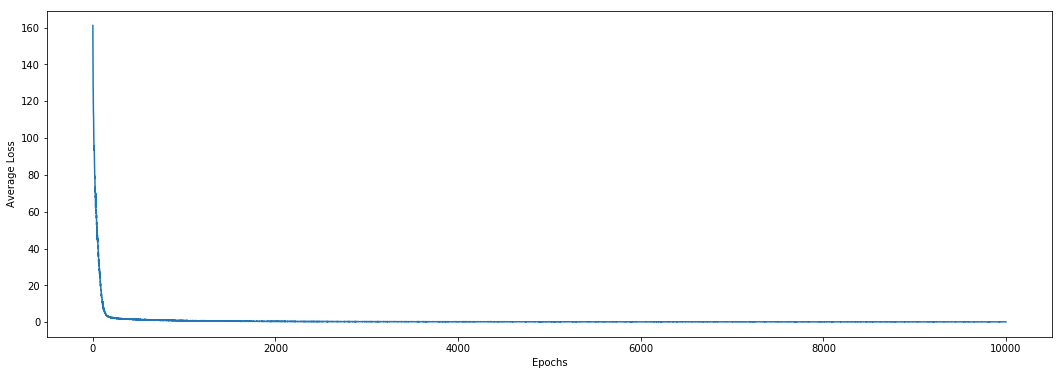

In [119]:
list_loss = np.array(avg_loss_record)
plt.figure(figsize=(18, 6))
plt.plot([i for i in range(len(list_loss))], list_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [60]:
#tf.reset_default_graph()

In [120]:
vector = tf.placeholder(dtype=tf.float32)
#Create similarity matrix
mult_vector = tf.matmul(vector, vector, transpose_b=True)
sim_matrix = tf.acos(mult_vector)

In [121]:
with tf.Session() as sess:
    matrices = sess.run([sim_matrix, mult_vector] , feed_dict={vector:final_embeddings})

In [122]:
sim_matrix = matrices[0]

In [123]:
sim_matrix = np.array([[value if value==value else 0 for value in row] for row in sim_matrix])

In [124]:
np.fill_diagonal(sim_matrix, 0)

In [125]:
#Similarity is based  on the batch inputs not on the batch labels!
#This is important
#batch_inputs

In [126]:
results = []
for idx_row, row in enumerate(sim_matrix):
    #print (row)
    top_n_scores = [row[i] for i in np.argsort(row)[:2]]
    top_n_nodes = [i for i in np.argsort(row)[:2]]
    results.append([top_n_scores[1], top_n_nodes[1]])

In [127]:
results = np.array(results)

In [128]:
np.argsort(results[:,0])

array([1009,  974,  387, ...,   14, 1564,  696], dtype=int64)

In [108]:
np.argsort(results[:,0])

array([1237,   76,  163, ...,  606,   14, 1564], dtype=int64)

In [132]:
results[387]

array([  3.99255514e-01,   1.40500000e+03])

In [133]:
sim = sim_matrix[387]

top_n_scores = [sim[i] for i in np.argsort(sim)[:5]]
top_n_nodes = [i for i in np.argsort(sim)[:5]]

bottom_n_scores = [sim[i] for i in np.argsort(sim)[-5:]]
bottom_n_nodes = [i for i in np.argsort(sim)[-5:]]

top_n_scores, top_n_nodes, bottom_n_scores, bottom_n_nodes

([0.0,
  0.39925551414489746,
  0.53175264596939087,
  0.72819960117340088,
  0.83264333009719849],
 [387, 1405, 484, 787, 1753],
 [1.5634257793426514,
  1.5679293870925903,
  1.570063591003418,
  1.5954756736755371,
  1.613917350769043],
 [496, 1519, 773, 1237, 1747])

In [111]:
sim = sim_matrix[1237]

top_n_scores = [sim[i] for i in np.argsort(sim)[:5]]
top_n_nodes = [i for i in np.argsort(sim)[:5]]

bottom_n_scores = [sim[i] for i in np.argsort(sim)[-5:]]
bottom_n_nodes = [i for i in np.argsort(sim)[-5:]]

top_n_scores, top_n_nodes, bottom_n_scores, bottom_n_nodes

([0.0,
  0.4110037088394165,
  0.68108248710632324,
  0.79184973239898682,
  0.82601290941238403],
 [1237, 76, 354, 1214, 1554],
 [1.6195741891860962,
  1.6275900602340698,
  1.6486058235168457,
  1.6683961153030396,
  1.713396430015564],
 [321, 1591, 1302, 1070, 433])

In [93]:
sim = sim_matrix[1670]

top_n_scores = [sim[i] for i in np.argsort(sim)[:5]]
top_n_nodes = [i for i in np.argsort(sim)[:5]]

bottom_n_scores = [sim[i] for i in np.argsort(sim)[-5:]]
bottom_n_nodes = [i for i in np.argsort(sim)[-5:]]

top_n_scores, top_n_nodes, bottom_n_scores, bottom_n_nodes

([0.0,
  0.74942821264266968,
  0.77965331077575684,
  0.77987837791442871,
  0.79354214668273926],
 [1670, 683, 1401, 1941, 642],
 [1.6037107706069946,
  1.6287198066711426,
  1.6358891725540161,
  1.6816208362579346,
  1.7215356826782227],
 [1052, 1008, 1819, 946, 1918])

In [88]:
#FIGURE OUT WHY THESE TWO ARE NOT SIMILAR
vocab_dict['https://support.google.com/a/answer/60217'], vocab_dict['https://support.google.com/a/answer/48323']

(8, 1670)

In [86]:
web_graph[vocab_dict['https://support.google.com/a/answer/60217']], \
web_graph[vocab_dict['https://support.google.com/a/answer/48323']]

(AtlasView({1519: {}}), AtlasView({1519: {}}))

In [134]:
[inv_map[i] for i in top_n_nodes]

['https://accounts.google.com/TOS?loc=JP&hl=en',
 'https://accounts.google.com/TOS?loc=JP&hl=en&privacy=true',
 'http://www.google.com/support/accounts?hl=en',
 'https://www.facebook.com/Cisco/?hc_ref=ARSNZvUnJQILAGB_jn4ViXMOjLe2M-N6-2zscffsc-37YqkfGMNwUezsWzEdtSCRDOY&fref=nf',
 'https://accounts.google.com/signin/usernamerecovery?continue=https%3A%2F%2Fphotos.google.com%2Flogin&osid=1&hl=en']

In [131]:
[inv_map[i] for i in top_n_nodes]

['https://www.whitehouse.gov/issues/economy-jobs/',
 'https://www.whitehouse.gov/issues/economy-jobs/?utm_source=link',
 'https://www.whitehouse.gov',
 'http://www.whitehouse.gov',
 'http://www.census.gov/topics/population/population-estimates.html']

In [112]:
[inv_map[i] for i in top_n_nodes]

['http://www.pewresearch.org/follow-us',
 'http://www.pewresearch.org/about',
 'http://www.people-press.org',
 'http://www.pewhispanic.org',
 'http://support.apple.com/kb/ht5343']

In [135]:
[web_graph[i] for i in top_n_nodes]

[AtlasView({1794: {}, 1027: {}, 1228: {}, 909: {}, 1618: {}, 643: {}, 180: {}, 629: {}, 1238: {}, 1112: {}, 924: {}, 1021: {}}),
 AtlasView({1794: {}, 1027: {}, 1228: {}, 909: {}, 1618: {}, 643: {}, 180: {}, 629: {}, 1238: {}, 1112: {}, 924: {}, 1021: {}}),
 AtlasView({924: {}, 1618: {}, 1027: {}, 643: {}, 629: {}, 1112: {}, 180: {}, 1794: {}, 1228: {}, 1021: {}, 909: {}}),
 AtlasView({1015: {}}),
 AtlasView({643: {}})]

In [113]:
[web_graph[i] for i in top_n_nodes]

[AtlasView({1632: {}, 66: {}, 939: {}, 676: {}, 166: {}, 1639: {}, 457: {}, 1547: {}, 76: {}, 354: {}, 81: {}, 114: {}, 1043: {}, 1237: {}, 822: {}, 665: {}, 189: {}, 1214: {}}),
 AtlasView({1632: {}, 66: {}, 939: {}, 676: {}, 457: {}, 1547: {}, 76: {}, 354: {}, 81: {}, 114: {}, 1043: {}, 1237: {}, 822: {}, 665: {}, 189: {}, 1214: {}}),
 AtlasView({1632: {}, 1043: {}, 676: {}, 1237: {}, 822: {}, 457: {}, 1547: {}, 76: {}, 939: {}}),
 AtlasView({76: {}, 1547: {}, 676: {}, 1237: {}, 457: {}}),
 AtlasView({136: {}})]

In [262]:
top_n_node_connections = [set([q for q in web_graph[i]]) for i in top_n_nodes]
bottom_n_node_connections = [set([q for q in web_graph[i]]) for i in bottom_n_nodes]

In [276]:
#top_n_node_connections, bottom_n_node_connections

In [264]:
[top_n_node_connections[0] & nodes for nodes in top_n_node_connections]

[{8284}, set(), set(), set(), set()]

In [265]:
[top_n_node_connections[0] & nodes for nodes in bottom_n_node_connections]

[set(), set(), set(), set(), set()]

In [ ]:
learning_grid = [50]
perplexity_grid = [15, 50, 100]

for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        tsne = TSNE(perplexity=perplexity, n_components=2, learning_rate=learning_rate, n_iter=40000, 
                    verbose=9, metric='precomputed')
        
        low_dim_embs = tsne.fit_transform(sim_matrix)
        pickle.dump(low_dim_embs, open('low_dim_embs_grid_%d_%d.pkl' % (learning_rate, perplexity), 'wb'))

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 1988 samples in 0.007s...
[t-SNE] Computed neighbors for 1988 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1988
[t-SNE] Computed conditional probabilities for sample 1988 / 1988
[t-SNE] Mean sigma: 0.197156
[t-SNE] Computed conditional probabilities in 0.050s
[t-SNE] Iteration 50: error = 86.1151962, gradient norm = 0.0000000 (50 iterations in 1.860s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 86.115196
[t-SNE] Iteration 100: error = 3.8736598, gradient norm = 0.0083495 (50 iterations in 1.996s)
[t-SNE] Iteration 150: error = 2.8891404, gradient norm = 0.0014825 (50 iterations in 1.800s)
[t-SNE] Iteration 200: error = 2.6768491, gradient norm = 0.0007408 (50 iterations in 1.770s)
[t-SNE] Iteration 250: error = 2.5600963, gradient norm = 0.0004670 (50 iterations in 1.773s)
[t-SNE] Iteration 300: error = 2.4869149, 

In [285]:
tsne = TSNE(perplexity=10, n_components=2, learning_rate=1, n_iter=50000, verbose=9, metric='precomputed')
low_dim_embs = tsne.fit_transform(sim_matrix)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8787 samples in 0.097s...
[t-SNE] Computed neighbors for 8787 samples in 1.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8787
[t-SNE] Computed conditional probabilities for sample 2000 / 8787
[t-SNE] Computed conditional probabilities for sample 3000 / 8787
[t-SNE] Computed conditional probabilities for sample 4000 / 8787
[t-SNE] Computed conditional probabilities for sample 5000 / 8787
[t-SNE] Computed conditional probabilities for sample 6000 / 8787
[t-SNE] Computed conditional probabilities for sample 7000 / 8787
[t-SNE] Computed conditional probabilities for sample 8000 / 8787
[t-SNE] Computed conditional probabilities for sample 8787 / 8787
[t-SNE] Mean sigma: 0.160281
[t-SNE] Computed conditional probabilities in 0.141s
[t-SNE] Iteration 50: error = 109.2683563, gradient norm = 0.0000058 (50 iterations in 11.066s)
[t-SNE] Iteration 100: error = 109.2683563, gradient norm = 0.0000004 (50 iterations in

[t-SNE] Iteration 3900: error = 4.3404908, gradient norm = 0.0002171 (50 iterations in 9.252s)
[t-SNE] Iteration 3950: error = 4.3324389, gradient norm = 0.0002132 (50 iterations in 9.290s)
[t-SNE] Iteration 4000: error = 4.3245025, gradient norm = 0.0002091 (50 iterations in 9.226s)
[t-SNE] Iteration 4050: error = 4.3167462, gradient norm = 0.0002054 (50 iterations in 9.159s)
[t-SNE] Iteration 4100: error = 4.3090367, gradient norm = 0.0002018 (50 iterations in 9.226s)
[t-SNE] Iteration 4150: error = 4.3015528, gradient norm = 0.0001984 (50 iterations in 9.200s)
[t-SNE] Iteration 4200: error = 4.2942495, gradient norm = 0.0001954 (50 iterations in 9.211s)
[t-SNE] Iteration 4250: error = 4.2870688, gradient norm = 0.0001923 (50 iterations in 9.234s)
[t-SNE] Iteration 4300: error = 4.2799435, gradient norm = 0.0001889 (50 iterations in 9.351s)
[t-SNE] Iteration 4350: error = 4.2730079, gradient norm = 0.0001862 (50 iterations in 9.096s)
[t-SNE] Iteration 4400: error = 4.2662263, gradien

[t-SNE] Iteration 8200: error = 3.9787662, gradient norm = 0.0000824 (50 iterations in 9.216s)


KeyboardInterrupt: 

In [242]:
#pickle.dump(low_dim_embs, open('low_dim_embs_karate_club.pkl', 'wb'))

In [8]:
%matplotlib notebook
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

In [10]:
labels = [i for i in range(0, len(web_graph.nodes()), 1)]

#pickle.dump(low_dim_embs, open('low_dim_embs.pkl', 'wb'))

#low_dim_embs = pickle.load(open('low_dim_embs_grid_1_5.pkl', 'rb'))

In [15]:
learning_grid = [1, 10, 50]
perplexity_grid = [5, 15, 50]
for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        low_dim_embs = pickle.load(open('low_dim_embs_grid_%d_%d.pkl' % (learning_rate, perplexity), 'rb'))
        
        fig, ax = plt.subplots()

        points = ax.plot(low_dim_embs[:,0], low_dim_embs[:,1], 'o', color='b',
                     mec='k', ms=5, mew=1, alpha=.6)
        fig.savefig('low_dim_embs_grid_%d_%d.png' % (learning_rate, perplexity))

#tooltip = plugins.PointHTMLTooltip(points[0], labels)

#plugins.connect(fig, tooltip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: 'low_dim_embs_grid_50_5.pkl'

In [12]:
#mpld3.display()

In [179]:
#plt.figure(figsize=(10, 10))
nx.draw_networkx(web_graph, with_labels=True, node_size=50, arrows=False)
plt.show()

In [46]:
results[14]

array([ 1.89316559,  0.92058927,  1.45331097,  1.20190859,  1.14429533,
        0.79873216,  0.58146346,  1.08515716,  1.04885304,  1.11311364,
        0.63541526,  1.38222861,  1.25472403,  1.53170264,  0.        ,
        1.09863055,  1.24171519,  1.49786341,  0.84771544,  1.76275682,
        0.74969655,  1.26779151,  1.00599658,  0.9319672 ,  1.20524192,
        0.97492516,  1.1583147 ,  1.49007535,  1.15756428,  1.15787256,
        0.83833277,  1.61629784,  1.09607387,  0.99879616], dtype=float32)

In [48]:
results[22]

array([ 2.12768841,  0.95966452,  1.16453874,  1.53453577,  1.35475671,
        1.25087941,  1.02873313,  1.10538161,  0.68419492,  1.37566459,
        1.03665698,  1.20357859,  1.51137674,  1.66352248,  1.00599658,
        0.91914564,  1.3249526 ,  1.60193515,  1.20680094,  1.49263489,
        0.93455303,  1.75604236,  0.        ,  0.92661941,  1.08651865,
        1.09799027,  1.3243686 ,  1.42965853,  1.64990151,  1.52092946,
        0.84679461,  1.43893862,  1.36679614,  1.29531991], dtype=float32)